In [21]:
import logging
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import random
from ftovopt.logic.bdcu_jmx import BdcuJMX
from ftovopt.config.logger import initialize_logging
from ftovopt.logic.ghost_beam import GhostBeam
import json
import time
%matplotlib notebook
from scipy.optimize import curve_fit

In [22]:
config_file_path = "./ftovopt/config/log.conf"
initialize_logging(config_file_path)

logger = logging.getLogger(__name__)
configFile="./ftovopt/config/config.json"
with open(configFile) as configJson:
    config = json.load(configJson)

bdcu=BdcuJMX(config)
bdcu.connect()

ERROR:  Error with the local JVM
INFO:  Connection to JMX


C:\Users\sebas\Dropbox\ABC-DEV\Projects\IBA\Technical\RF characterization\ftovoptimization\logs\ftovopt.log


INFO:  Connected to JMX


In [23]:
def build_ghost_beam_setpoints(nb_accelerated_pulses,nb_ghost_beam_pulses,nb_cleanup_pulses,nb_repetition_in_map):
    acceleration=np.zeros((nb_accelerated_pulses,2))
    acceleration[:,0]=100.0
    acceleration[:,1]=8.5

    ghost_beam=np.zeros((nb_ghost_beam_pulses,2))
    ghost_beam[:,0]=0.0
    ghost_beam[:,1]=0.0

    cleanup=np.zeros((nb_cleanup_pulses,2))
    cleanup[:,0]=100.0
    cleanup[:,1]=0.0

    one_measure=np.vstack([acceleration,ghost_beam,cleanup])

    return np.tile(one_measure,(nb_repetition_in_map,1))

def parse_ghost_beam_logs(logs,nb_accelerated_pulses,nb_ghost_beam_pulses,nb_cleanup_pulses,nb_repetition_in_map):
    #Expected format:
    #output_logs[:,0]: ic_cyclo_small_gap - in protons
    #output_logs[:,1]: ic_cyclo_large_gap - in protons
    #output_logs[:,2]: beam_stop - in protons
    #output_logs[:,3]: vdee feedbacks at capture - in V
    #output_logs[:,4]: iarc feedbacks at capture - in V

    max_beam_pulses=[]
    ghost_beam_pulses=[]

    for i in range(nb_repetition_in_map):
        frame_size=(nb_accelerated_pulses+nb_ghost_beam_pulses+nb_cleanup_pulses)
        max_beam_pulses.append(logs[i*frame_size:i*frame_size+nb_accelerated_pulses,0])
        ghost_beam_pulses.append(logs[i*frame_size+nb_accelerated_pulses:i*frame_size+nb_accelerated_pulses+nb_ghost_beam_pulses,1])


    return (np.vstack(max_beam_pulses),np.vstack(ghost_beam_pulses))

In [123]:
nb_ghost_beam_pulses=200
nb_cleanup_pulses=50
nb_accelerated_pulses=70
nb_repetition_in_map=100

print("Map size: {0}".format((nb_accelerated_pulses+nb_ghost_beam_pulses+nb_cleanup_pulses)*nb_repetition_in_map))

Map size: 32000


In [124]:


setpoints=build_ghost_beam_setpoints(nb_accelerated_pulses,nb_ghost_beam_pulses,nb_cleanup_pulses,nb_repetition_in_map)
logs=bdcu.send_cyclo_burst(setpoints)
[max_beam_pulses,ghost_beam_pulses]=parse_ghost_beam_logs(logs,nb_accelerated_pulses,nb_ghost_beam_pulses,nb_cleanup_pulses,nb_repetition_in_map)


In [125]:
filename="ghost_beam_acquisitions/good_ftov"
unixtime = int(time.time())
np.save("{0}-{1}-{2}-{3}-{4}-{5}-max-beam.npy".format(filename,nb_accelerated_pulses,nb_ghost_beam_pulses,nb_cleanup_pulses,nb_repetition_in_map,unixtime),max_beam_pulses)
np.save("{0}-{1}-{2}-{3}-{4}-{5}-ghost-beam.npy".format(filename,nb_accelerated_pulses,nb_ghost_beam_pulses,nb_cleanup_pulses,nb_repetition_in_map,unixtime),ghost_beam_pulses)


Ghost beam mean: 8.536792692019624e-13. Std: 5.3699808543004185e-14


<IPython.core.display.Javascript object>


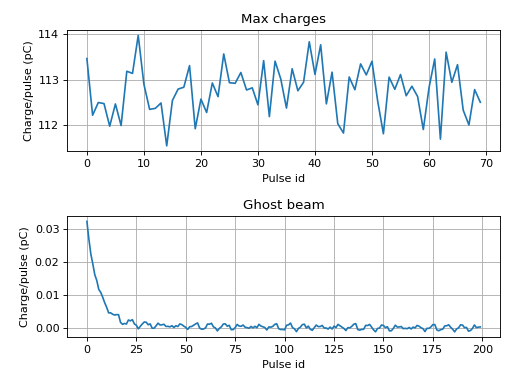

<IPython.core.display.Javascript object>


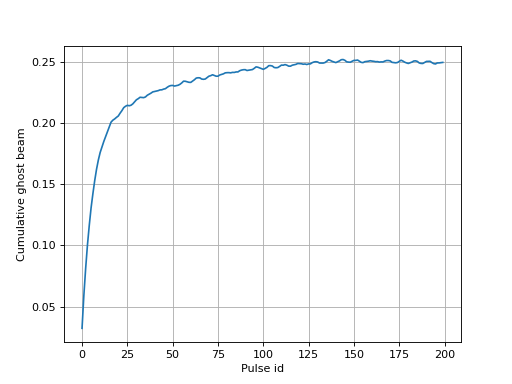

<IPython.core.display.Javascript object>


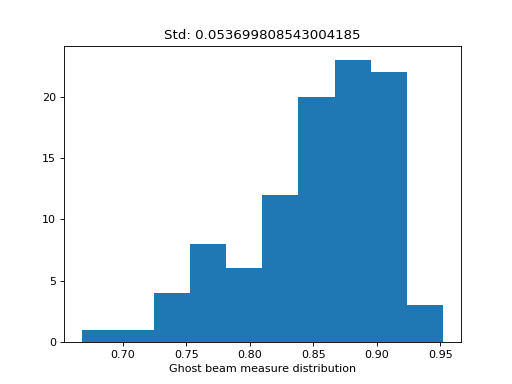

Text(0.5, 1.0, 'Std: 0.053699808543004185')

In [126]:

max_beam_average=np.mean(max_beam_pulses,axis=0)
ghost_beam_average=np.mean(ghost_beam_pulses,axis=0)

ghost_beam_per_iteration=np.sum(ghost_beam_pulses,axis=1)
print("Ghost beam mean: {0}. Std: {1}".format(np.mean(ghost_beam_per_iteration),np.std(ghost_beam_per_iteration)))

noise=ghost_beam_average[-10:].mean()

fig,ax=plt.subplots(2,1)
ax[0].plot(max_beam_average*1E12)
ax[1].plot((ghost_beam_average-noise)*1E12)
ax[0].grid()
ax[1].grid()
ax[0].set_xlabel("Pulse id")
ax[0].set_title("Max charges")
ax[0].set_ylabel("Charge/pulse (pC)")
ax[1].set_xlabel("Pulse id")
ax[1].set_title("Ghost beam")
ax[1].set_ylabel("Charge/pulse (pC)")

plt.tight_layout()

plt.figure()
plt.plot(np.cumsum(ghost_beam_average-noise)*1E12)
plt.xlabel("Pulse id")
plt.ylabel("Cumulative ghost beam")

plt.grid()

plt.figure()
plt.hist(ghost_beam_per_iteration*1E12)
plt.xlabel("Ghost beam measure distribution")
plt.title("Std: {0}".format(np.std(ghost_beam_per_iteration)*1E12))

In [113]:
np.load("ghost_beam_acquisitions/first-test-1656240401-ghost-beam.npy").shape

(10, 700)

<IPython.core.display.Javascript object>


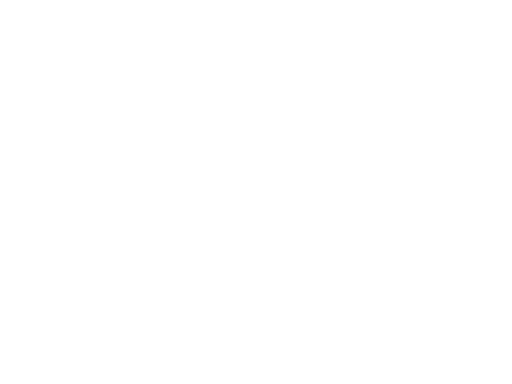

KeyboardInterrupt: 

In [114]:
sweep=[1,5,10,20,30]
plt.figure()

for nb_cleanup_pulses in sweep:
    setpoints=build_ghost_beam_setpoints(nb_accelerated_pulses,nb_ghost_beam_pulses,nb_cleanup_pulses,nb_repetition_in_map)
    logs=bdcu.send_cyclo_burst(setpoints)
    [max_beam_pulses,ghost_beam_pulses]=parse_ghost_beam_logs(logs,nb_accelerated_pulses,nb_ghost_beam_pulses,nb_cleanup_pulses,nb_repetition_in_map)
    filename="ghost_beam_acquisitions/bad_ftov"
    unixtime = int(time.time())
    np.save("{0}-{1}-{2}-{3}-{4}-{5}-max-beam.npy".format(filename,nb_accelerated_pulses,nb_ghost_beam_pulses,nb_cleanup_pulses,nb_repetition_in_map,unixtime),max_beam_pulses)
    np.save("{0}-{1}-{2}-{3}-{4}-{5}-ghost-beam.npy".format(filename,nb_accelerated_pulses,nb_ghost_beam_pulses,nb_cleanup_pulses,nb_repetition_in_map,unixtime),ghost_beam_pulses)
    max_beam_average=np.mean(max_beam_pulses,axis=0)
    ghost_beam_average=np.mean(ghost_beam_pulses,axis=0)

    ghost_beam_per_iteration=np.sum(ghost_beam_pulses,axis=1)
    print("Ghost beam mean: {0}. Std: {1}".format(np.mean(ghost_beam_per_iteration),np.std(ghost_beam_per_iteration)))

    noise=ghost_beam_average[-10:].mean()
    plt.plot(np.cumsum(ghost_beam_average-noise)*1E12,label="nb_cleaning_pulses={0}".format(nb_cleanup_pulses))

plt.xlabel("Pulse id")
plt.ylabel("Cumulative ghost beam")
plt.legend()
plt.tight_layout()

In [127]:
datas=[]
for i in range(len(ghost_beam_per_iteration)):
    datas.append(np.mean(ghost_beam_per_iteration[:i]))

C:\Users\sebas\Dropbox\ABC-DEV\Projects\IBA\Technical\RF characterization\ftovoptimization\venv\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\sebas\Dropbox\ABC-DEV\Projects\IBA\Technical\RF characterization\ftovoptimization\venv\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


<IPython.core.display.Javascript object>


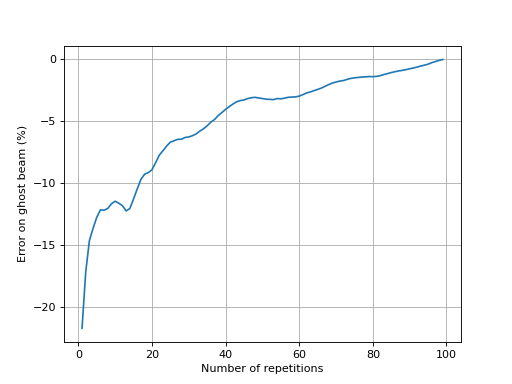

Text(0, 0.5, 'Error on ghost beam (%)')

In [128]:
plt.figure()
plt.plot((datas/np.mean(ghost_beam_per_iteration)-1)*100)
plt.grid()
plt.xlabel("Number of repetitions")
plt.ylabel("Error on ghost beam (%)")

<IPython.core.display.Javascript object>


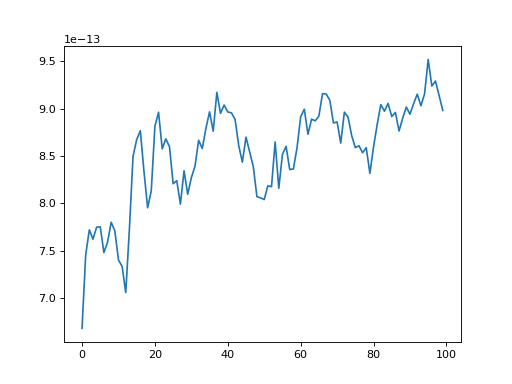

In [129]:
plt.figure()
plt.plot(ghost_beam_per_iteration)